Details of both of datasets are available at https://openproblems.bio/neurips_docs/data/dataset/. Details on multi-modal single-cell data in general can be found here https://openproblems.bio/neurips_docs/data/about_multimodal/.

The data is completely preprocessed and contains the necessary annotations for benchmarking integration methods.

Let's start by loading some necessary libraries:

In [ ]:
!pip install scanpy episcanpy scikit-misc leidenalg matplotlib==3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scanpy-1.9.1-py3-none-any.whl (2.0 MB)
  Using cached episcanpy-0.4.0.tar.gz (50.5 MB)
  Using cached scikit_misc-0.1.4-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (8.8 MB)
  Using cached leidenalg-0.9.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached matplotlib-3.1.1-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Using cached scanpy-1.9.0-py3-none-any.whl (2.0 MB)
  Using cached scanpy-1.8.2-py3-none-any.whl (2.0 MB)
  Using cached scanpy-1.8.1-py3-none-any.whl (2.0 MB)
  Using cached scanpy-1.8.0-py3-none-any.whl (11.3 MB)
  Using cached scanpy-1.7.2-py3-none-any.whl (10.3 MB)
  Using cached scanpy-1.7.1-py3-none-any.whl (10.3 MB)
  Using cached scanpy-1.7.0-py3-none-any.whl (10.2 MB)
  Using cached scanpy-1.6.1-py3-none-any.whl (10.2 MB)
  Using cached scanpy-1.6.0-py3-none-any.whl (7.7 MB)
  Using cached scanpy-1.5.1-py3-none-an

In [3]:
import os
import gzip

import numpy as np
import pandas as pd
import scanpy as sc 
import episcanpy as esc
import anndata as ann

ModuleNotFoundError: No module named 'numpy'

Mount Google Drive and unzip the dataset.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Colab\ Notebooks/single-cell-sequencing
%ls

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks/single-cell-sequencing
01_multimodal_autoencoder_cite_data.ipynb
02_multimodal_concat_cite_data.ipynb
eval_embeddings.py
GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad
GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz
GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad.gz
__pycache__/


In [ ]:
import shutil
with gzip.open('GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz', 'rb') as f_in:
    with open('GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [ ]:
cite = sc.read_h5ad('GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad')

We know that the **.X** attribute is supposed to store the counts, but we have two modalities now. Data for both of them will be stored in .X. To subset .X for each individual modality, we can use the .var frame object in the following way:

In [ ]:
gex = cite[:, cite.var["feature_types"] == "GEX"]
gex.shape

(90261, 13953)

In [ ]:
adt = cite[:, cite.var["feature_types"] == "ADT"]
adt.shape

(90261, 134)

Feature selection. Skip for ADT since there are only 134 features.

In [ ]:
sc.pp.highly_variable_genes(gex, n_top_genes=2500, flavor="seurat_v3")

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

Converting GEX to tensor.

In [ ]:
hvg_indices = gex.var["highly_variable"]
gex_arr = gex.X.todense()[:, hvg_indices]
gex_tensor = tf.convert_to_tensor(gex_arr)

Converting ADT to tensor.

In [ ]:
adt_arr = adt.X.todense()
adt_tensor = tf.convert_to_tensor(adt_arr)

In [ ]:
print(adt_tensor.shape, gex_tensor.shape)

(90261, 134) (90261, 2500)


In [ ]:
gex_adt_concat = tf.concat([gex_tensor, adt_tensor], axis = 1)
gex_adt_concat.shape

TensorShape([90261, 2634])

In [ ]:
latent_gex = 8
latent_adt = 12
gex_dim = 2500
adt_dim = 134

# Create the model class for our AutoEncoder - this follows mostly for the tutorial from 
# https://www.tensorflow.org/tutorials/generative/autoencoder, except we're putting a multi-modal
# flavor on it and ensuring it uses and reconstructs both GEX and ADT outputs 
class MultiModalAutoencoder(Model):
    def __init__(self, latent_gex, latent_adt, gex_dim, adt_dim):
        super(MultiModalAutoencoder, self).__init__()
        self.latent_gex = latent_gex
        self.latent_adt = latent_adt
        self.gex_dim = gex_dim
        self.adt_dim = adt_dim
        # We have two encoders and decoder - for each modality
        # We divide latent dim by two because we are going to 
        # concatenate the two modalities in latent space and
        # then use that concatenated representation to reconstruct
        # each modality 
        self.gex_encoder = tf.keras.Sequential([
            layers.Dense(2100, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.01),
            layers.Dense(1600, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(1200, activation="relu"),
            layers.Dropout(0.01),
            layers.Dense(900, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(300, activation="relu"),
            layers.Dropout(0.01),
            layers.Dense(100, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(latent_gex, activation="relu")
        ])
        self.adt_encoder = tf.keras.Sequential([
            layers.Dense(100, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.01),
            layers.Dense(90, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(60, activation="relu"),
            layers.Dropout(0.01),
            layers.Dense(30, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(24, activation="relu"),
            layers.Dropout(0.01),
            layers.Dense(16, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(latent_adt, activation="relu")
        ])
        self.latent_concat = tf.keras.layers.Concatenate(
            axis=-1
        )
        self.outputs_concat = tf.keras.layers.Concatenate(
            axis=-1
        )
        self.gex_decoder = tf.keras.Sequential([
            layers.Dense(100, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(300, activation="relu"),
            layers.Dropout(0.01),
            layers.Dense(900, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(1200, activation="relu"),
            layers.Dropout(0.01),
            layers.Dense(1600, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.01),
            layers.Dense(2100, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(gex_dim, activation = "relu")
        ])
        self.adt_decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(24, activation="relu"),
            layers.Dropout(0.01),
            layers.Dense(30, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(60, activation="relu"),
            layers.Dropout(0.01),
            layers.Dense(90, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.01),
            layers.Dense(100, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(adt_dim, activation = "relu")
        ])
        
    def call(self, gex_adt_X):
        # Extract the data
        gex_X = gex_adt_X[:, 0:2500]
        adt_X = gex_adt_X[:, 2500:]
        # Encode both the GEX and ADT data 
        gex_Z = self.gex_encoder(gex_X)
        adt_Z = self.adt_encoder(adt_X)
        # Concatenate the two encoded modalities 
        gex_adt_c = self.latent_concat([gex_Z, adt_Z]) # This is our latent we'll use later
        # Use the concatenated representation to recover both GEX and ADT
        gex_X_decoded = self.gex_decoder(gex_Z)
        adt_X_decoded = self.adt_decoder(adt_Z)
        gex_adt_X_decoded = self.outputs_concat([gex_X_decoded, adt_X_decoded])
        return gex_adt_X_decoded 
    
# I guess we can use the same loss fuction for both modalities
def multimodal_loss(gex_adt_true, gex_adt_pred):
    # GEX loss 
    mse = tf.keras.losses.MeanSquaredError()
    gex_true = gex_adt_true[:, 0:2501]
    gex_pred = gex_adt_pred[:, 0:2501]
    gex_loss = mse(gex_true, gex_pred)

    #ADT loss
    adt_true = gex_adt_true[:, 2501:]
    adt_pred = gex_adt_pred[:, 2501:]
    adt_loss = mse(adt_true, adt_pred)

    loss = latent_gex / (latent_gex+latent_adt) * gex_loss + latent_adt / (latent_gex+latent_adt) * adt_loss
    
    return loss 

In [ ]:
autoencoder = MultiModalAutoencoder(latent_gex, latent_adt, gex_dim, adt_dim)
autoencoder.compile(optimizer='adam', loss=multimodal_loss)

In [ ]:
autoencoder.fit(gex_adt_concat, gex_adt_concat,
                epochs=20,
                shuffle=True,
                batch_size=512
               )

Epoch 1/20
177/177 [==============================] - 287s 2s/step - loss: 45903.2852
Epoch 2/20
177/177 [==============================] - 276s 2s/step - loss: 42422.3828
Epoch 3/20
177/177 [==============================] - 267s 2s/step - loss: 38372.5117
Epoch 4/20
177/177 [==============================] - 264s 1s/step - loss: 34339.7070
Epoch 5/20
177/177 [==============================] - 267s 2s/step - loss: 29859.9961
Epoch 6/20
177/177 [==============================] - 270s 2s/step - loss: 26182.3301
Epoch 7/20
177/177 [==============================] - 271s 2s/step - loss: 23474.2051
Epoch 8/20
177/177 [==============================] - 269s 2s/step - loss: 20793.2793
Epoch 9/20
177/177 [==============================] - 269s 2s/step - loss: 19035.0859
Epoch 10/20
177/177 [==============================] - 269s 2s/step - loss: 17528.2344
Epoch 11/20
177/177 [==============================] - 266s 2s/step - loss: 16317.5049
Epoch 12/20
177/177 [==============================]

In [ ]:
# Free RAM
del gex
del gex_arr
del adt_arr

In [ ]:
autoencoder.trainable = False # Freezes model

In [ ]:
gex_Z = autoencoder.gex_encoder(gex_tensor) # Get GEX reduction 
gex_Z.shape

TensorShape([90261, 8])

In [ ]:
adt_Z = autoencoder.adt_encoder(adt_tensor) # Get ADT reduction
adt_Z.shape

TensorShape([90261, 12])

In [ ]:
Z_concat = tf.concat([gex_Z, adt_Z], axis = 1)
Z_concat.shape

TensorShape([90261, 20])

In [ ]:
Z_concat_arr = Z_concat.numpy()
Z_concat_arr.shape

(90261, 20)

In [ ]:
from eval_embeddings import EvalEmbeddings

In [ ]:
eval_obj = EvalEmbeddings(adata=adt) # Initialize the class
eval_obj.evaluate(Z_concat_arr) # Evaluate

(0.5514475917266264,
    celltype_ari  celltype_ami  celltype_homogeneity  celltype_complete  \
 0      0.222245      0.578666              0.648735           0.524652   
 
    batch_ari  batch_ami  batch_homogeneity  batch_complete  
 0   0.837497   0.586222           0.469002        0.660306  )

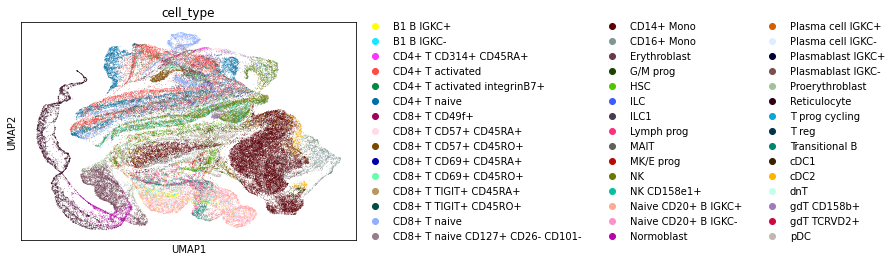

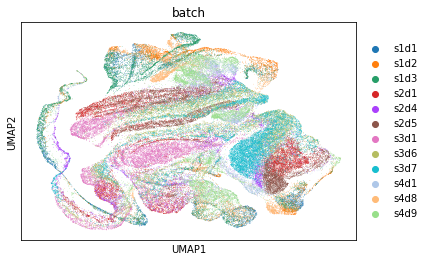

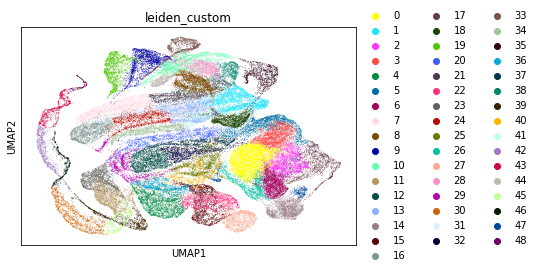

In [ ]:
eval_obj.plot() # Plot the results 
del gex_Z
del adt_Z
del Z_concat
del Z_concat_arr

Results:
1. Shallow autoencoder with shared loss between modalities, latent partition 1:1, 10 epochs: 0.4656
2. Deeper autoencoder with with two losses for each modality, latent partition 1:1, 20 epochs: 0.5829
3. Latent partition 1:4, 20 epochs: 0.580156
4. Latent partition 4:1, 20 epochs: 0.569606
5. Latent partition 2:3: 0.551447